In [1]:
import os
import glob
import gdal_merge

In [2]:
os.getcwd()

'/Users/clunch/sandbox'

In [2]:
files_to_mosaic = glob.glob('./TEAK_Aspect_Tiles/*_aspect.tif')
files_to_mosaic

['./TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_320000_4100000_aspect.tif',
 './TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_320000_4101000_aspect.tif',
 './TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_321000_4100000_aspect.tif',
 './TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_321000_4101000_aspect.tif']

Had to turn the slashes the opposite direction here

In [3]:
files_string = " ".join(files_to_mosaic)
print(files_string)

./TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_320000_4100000_aspect.tif ./TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_320000_4101000_aspect.tif ./TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_321000_4100000_aspect.tif ./TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_321000_4101000_aspect.tif


In [4]:
command = "python gdal_merge.py -o TEAK_Aspect_Mosaic.tif -of gtiff " + files_string
os.system(command)

0

Got 256 instead of 0 here. Does it matter? Seems to, TEAK_Aspect_Mosaic.tif hasn't been created

In [30]:
import osgeo
import gdal

Adding this made no difference

In [5]:
import numpy as np
from osgeo import gdal

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        #array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
            #band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

In [6]:
TEAK_aspect_array, TEAK_aspect_metadata = raster2array('TEAK_Aspect_Mosaic.tif')

In [7]:
TEAK_aspect_array.shape

(2000, 2000)

In [8]:
for item in sorted(TEAK_aspect_metadata):
    print(item + ':', TEAK_aspect_metadata[item])

array_cols: 2000
array_rows: 2000
bands: 1
driver: GeoTIFF
extent: (320000.0, 322000.0, 4100000.0, 4102000.0)
geotransform: (320000.0, 1.0, 0.0, 4102000.0, 0.0, -1.0)
noDataValue: None
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
scaleFactor: 1.0


In [9]:
import matplotlib.pyplot as plt

def plot_array(array,refl_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=refl_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

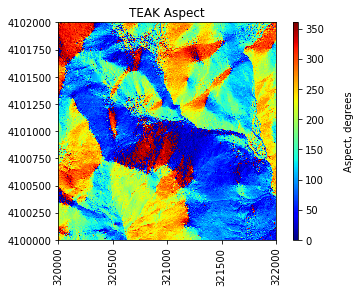

In [10]:
plot_array(TEAK_aspect_array,
           TEAK_aspect_metadata['extent'],
           (0,360),
           title='TEAK Aspect',
           cmap_title='Aspect, degrees',
           colormap='jet')